<center> <font size=6> Stock market prediction: CNN, hybrid CNN-LSTM, encoder-decoder multi-step LSTM </font></center>

In [43]:
!pip install pandas-datareader

In [117]:
from pandas_datareader import data
from datetime import datetime

nasdaq = data.DataReader('^IXIC', 'yahoo', '2007-01-05')
nasdaq.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-05,2445.070068,2420.590088,2445.070068,2434.250000,2060360000,2434.250000
2007-01-08,2445.629883,2421.129883,2435.250000,2438.199951,1905620000,2438.199951
2007-01-09,2449.870117,2423.560059,2443.260010,2443.830078,2144160000,2443.830078
2007-01-10,2461.340088,2427.899902,2434.040039,2459.330078,2274210000,2459.330078
2007-01-11,2489.459961,2463.389893,2464.889893,2484.850098,2436270000,2484.850098


In [118]:
nasdaq.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-15,11244.459961,11127.980469,11193.959961,11190.320312,3772820000,11190.320312
2020-09-16,11245.419922,11046.429688,11222.080078,11050.469727,3661710000,11050.469727
2020-09-17,10974.450195,10783.809570,10796.049805,10910.280273,3726750000,10910.280273
2020-09-18,10977.679688,10639.950195,10973.450195,10793.280273,5745690000,10793.280273
2020-09-21,10782.738281,10519.493164,10610.099609,10778.797852,3499370481,10778.797852


In [119]:
nasdaq.shape

(3452, 6)

In [120]:
nasdaq=nasdaq[["Close"]]
nasdaq=nasdaq.values

In [121]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y =list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [122]:
n_steps = 4
# split into samples
X, y = split_sequence(nasdaq, n_steps)

In [123]:
X.shape

(3448, 4, 1)

In [124]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import pandas as pd

### CNN

In [125]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [126]:
import numpy as np
yhat=model.predict(X)
print('RMSE:', np.sqrt(mean_squared_error(y, yhat)))

RMSE: 113.59036372150175


In [127]:
x_input = array([10919.58984,10853.54981,11056.65039,11190.32031,11050.46973,10910.28027,10793.28,10778.797852])
x_input = x_input.reshape((2,4,1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[10828.661]
 [10712.095]]


### Hybrid CNN-LSTM

In [128]:
X = X.reshape((X.shape[0], 2, 2, 1))
X.shape

(3448, 2, 2, 1)

In [129]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(120, activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

In [130]:
yhat=model.predict(X)
print('RMSE:', np.sqrt(mean_squared_error(y, yhat)))

RMSE: 90.9594445671262


In [131]:
X=array([10919.58984,10853.54981,11056.65039,11190.32031,11050.46973,10910.28027,10793.28,10778.797852])
X= X.reshape(2, 2, 2, 1)
model.predict(X, verbose=0)

array([[11058.828],
       [10627.799]], dtype=float32)

### Encoder-decoder LSTM multi-step

In [105]:
n_steps = 4
# split into samples
X, y = split_sequence(nasdaq, n_steps)

In [106]:
X.shape

(3448, 4, 1)

In [110]:
y = y.reshape((y.shape[0], y.shape[1], 1))
y.shape

(3448, 1, 1)

In [111]:
model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(n_steps, n_features)))
model.add(RepeatVector(1))
model.add(LSTM(120, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [115]:
yhat=model.predict(X)
yhat=yhat.reshape(yhat.shape[0],1)
y=y.reshape(y.shape[0],1)
print('RMSE:', np.sqrt(mean_squared_error(y, yhat)))

RMSE: 78.74437136930628


In [116]:
x_input = array([10919.58984,10853.54981,11056.65039,11190.32031,11050.46973,10910.28027,10793.28,10778.797852])
x_input = x_input.reshape((2,4,1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[11024.576]]

 [[10750.846]]]


### Summary

In [134]:
model=['CNN','CNN-LSTM','multi-step LSTM']
model=pd.DataFrame(model).rename(columns={0:"Model"})

Tue=['10828.661','11058.828','11024.576']
Tue=pd.DataFrame(Tue).rename(columns={0:"9/22/2020"})

Wed=['10712.095','10627.799','10750.846']
Wed=pd.DataFrame(Wed).rename(columns={0:"9/23/2020"})

RMSE=['113.59036372150175','90.9594445671262','78.74437136930628']
RMSE=pd.DataFrame(RMSE).rename(columns={0:"RMSE"})

summary=pd.concat([model,Tue,Wed,RMSE],axis=1)
summary

,Model,9/22/2020,9/23/2020,RMSE
0,CNN,10828.661,10712.095,113.59036372150175
1,CNN-LSTM,11058.828,10627.799,90.9594445671262
2,multi-step LSTM,11024.576,10750.846,78.74437136930628


In [173]:
nasdaq = data.DataReader('^IXIC', 'yahoo', '2007-01-05')
nasdaq=nasdaq[["Close"]]
nasdaq.tail()

,Close
Date,
2020-09-15,11190.320312
2020-09-16,11050.469727
2020-09-17,10910.280273
2020-09-18,10793.280273
2020-09-21,10778.797852


In [174]:
diff=nasdaq.diff(axis=0).rename(columns={"Close":"Daily Change"}).reset_index()
diff.tail()

,Date,Daily Change
3447,2020-09-15,133.669922
3448,2020-09-16,-139.850586
3449,2020-09-17,-140.189453
3450,2020-09-18,-117.000000
3451,2020-09-21,-14.482422


In [175]:
import datetime

diff["Period"]=pd.to_datetime(diff["Date"]).dt.to_period("M")
diff=diff.set_index("Period").drop(["Date"],axis=1)
diff.tail()

,Daily Change
Period,
2020-09,133.669922
2020-09,-139.850586
2020-09,-140.189453
2020-09,-117.000000
2020-09,-14.482422


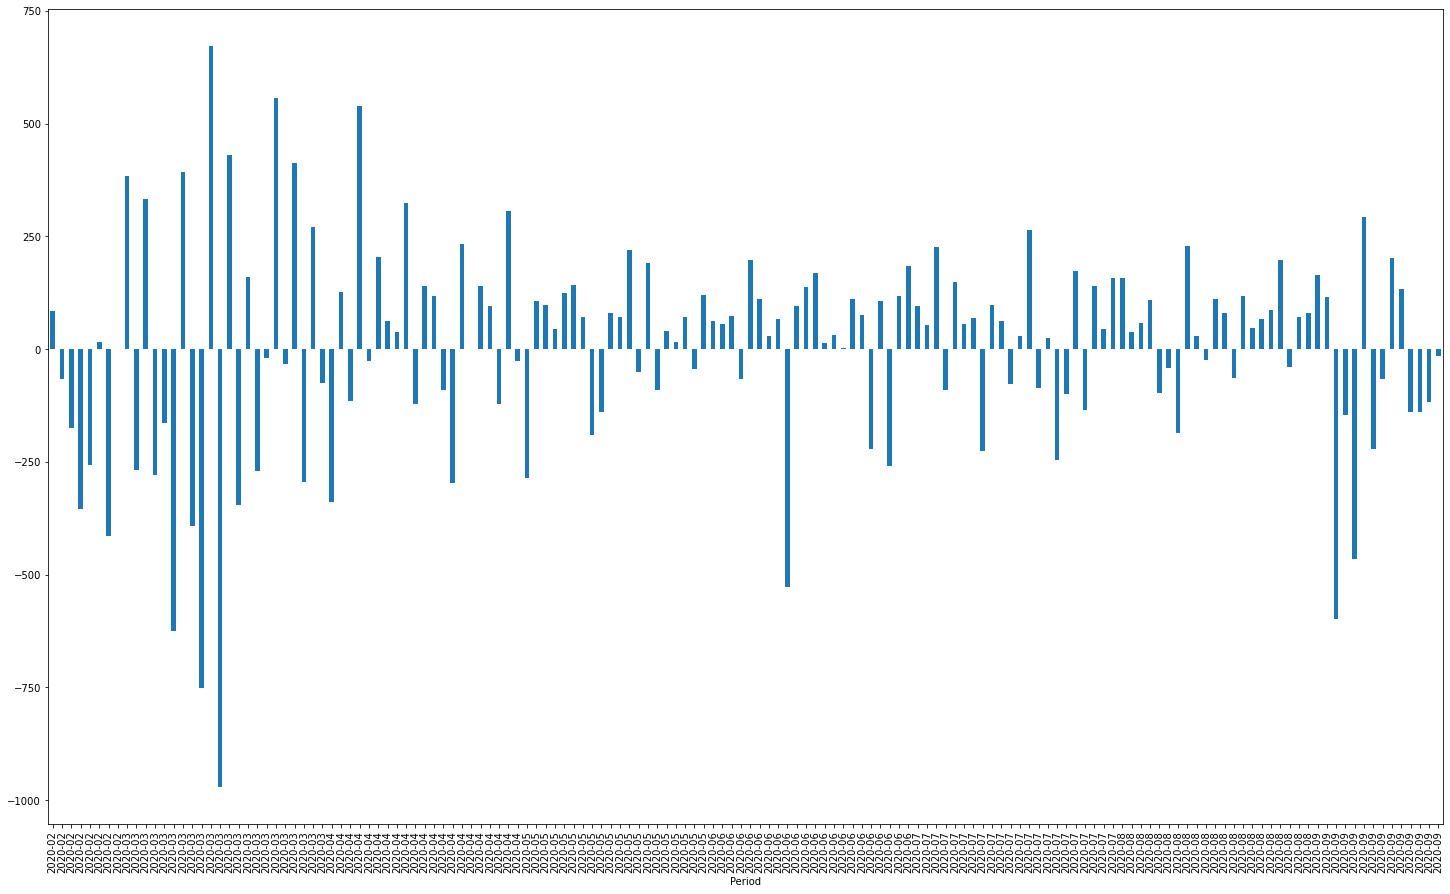

In [190]:
import matplotlib.pyplot as plt
sub_diff=diff[-150:]
sub_nasdaq=nasdaq[-150:]
plt.figure(figsize=(25,15))
sub_diff["Daily Change"].plot(kind='bar')
plt.xticks(rotation=90)
plt.savefig("Daily Change")